In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import mysql.connector

In [2]:
# data 불러오기
customer = pd.read_csv('data/Customer.csv')
transaction = pd.read_csv('data/Transactions.csv')
prod_info = pd.read_csv('data/prod_cat_info.csv')

### **EDA**

In [3]:
# 결측값 확인
# 성별, 거주지 코드에서 각각 2개씩 결측값 확인
customer.isnull().sum()

customer_Id    0
DOB            0
Gender         2
city_code      2
dtype: int64

In [4]:
# 결측치 삭제
customer = customer.dropna()

In [5]:
# 성별, 연령별 고객 수 파악해보기
# 고객 나이 계산
# 생년월일 변수 날짜형 타입으로 변환
customer['DOB'] = pd.to_datetime(customer['DOB'], format='%d-%m-%Y')

In [6]:
# 현재 날짜 설정 (2014년 3월 1일)
today = datetime(2014, 3, 1)

# 나이 계산
customer['age'] = customer['DOB'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))

# 나이 5세 단위로 범주화
# 나이의 최소값 : 21, 최대값 : 44
customer['age_cat'] = pd.cut(customer['age'], [0, 20, 25, 30, 35, 40, 45, 120], 
                            labels = ['< 20', '20 ~ 25', '26 ~ 30', '31 ~ 35', '36 ~ 40', '41 ~ 45', '> 46'])

In [7]:
# 성별, 연령별 고객 수 확인
# 연령대의 분포는 20대 ~ 40대까지 분포한다.
customer_counts = customer.groupby(['Gender', 'age_cat']).size().reset_index(name='count')
customer_counts 

,Gender,age_cat,count
0,F,< 20,0
1,F,20 ~ 25,601
2,F,26 ~ 30,596
3,F,31 ~ 35,588
4,F,36 ~ 40,605
5,F,41 ~ 45,362
6,F,> 46,0
7,M,< 20,0
8,M,20 ~ 25,603
9,M,26 ~ 30,623


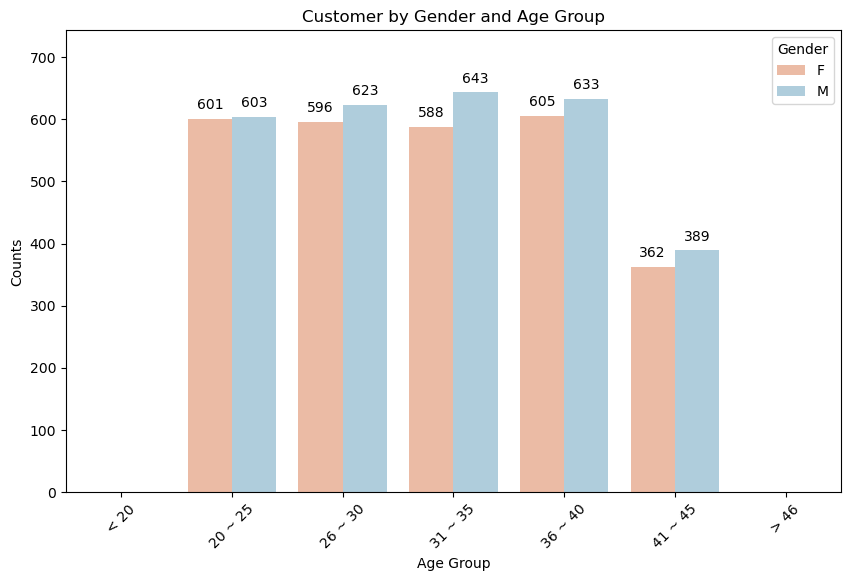

In [8]:
# 성별/연령별 고객 수 시각화
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='age_cat', y='count', hue='Gender', data=customer_counts, palette='RdBu')

# 막대 위에 count 수 표시
for p in barplot.patches:
    if p.get_height() > 0:  # count가 0보다 클 때만 라벨 표시
        barplot.annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points')

plt.title('Customer by Gender and Age Group')
plt.xlabel('Age Group')
plt.ylabel('Counts')
plt.xticks(rotation=45)

# y 축 범위 조정
barplot.set_ylim(0, customer_counts['count'].max() + 100)

plt.show()

In [9]:
# 구매 주기 파악해보기
# 거래 일자 날짜 형식으로 변경
# 일부 날짜가 년월일 구분이 /로 되어 있는 경우가 있어 - 로 바꿔주었다.
transaction['tran_date'] = transaction['tran_date'].str.replace('/', '-')
transaction['tran_date'] = pd.to_datetime(transaction['tran_date'], format='%d-%m-%Y')

In [10]:
# 구매 경과일수 = 기준일 - 마지막 구매일
# 기준일 설정 (2013년 2월 28일)
reference_date = pd.to_datetime('2013-02-28')

# 2013년 2월 28일 이전 기록만 추출
transaction_before_20130228 = transaction.loc[transaction['tran_date'] <= reference_date].reset_index(drop=True)

# 각 고객별 마지막 구매 날짜 찾기
last_purchase = transaction_before_20130228.groupby('cust_id')['tran_date'].max().reset_index()
last_purchase.rename(columns = {'tran_date' : 'last_date'}, inplace = True)

# 경과일수 계산
last_purchase['elapsed_days'] = (reference_date - last_purchase['last_date']).dt.days

# 구매주기 = (마지막 구매일 - 첫 구매일)/(총 구매 일수 - 1)
# 각 고객별 첫 구매 날짜 찾기
first_purchase = transaction_before_20130228.groupby('cust_id')['tran_date'].min().reset_index()
first_purchase.rename(columns = {'tran_date' : 'first_date'}, inplace = True)

# 총 구매 일수 구하기
days_purchase = transaction_before_20130228.groupby('cust_id')['tran_date'].count().reset_index()
days_purchase.rename(columns = {'tran_date' : 'purchase_days'}, inplace = True)

# 데이터 프레임 합치기
# 첫 구매, 마지막 구매 합치기
purchase_date_info_tmp1 = pd.merge(last_purchase, first_purchase, on='cust_id', how='outer')

# 위에서 합친 결과에 총 구매일 합치기
purchase_date_info_tmp2 = pd.merge(purchase_date_info_tmp1, days_purchase, on='cust_id', how='outer')

# 구매주기 계산
purchase_date_info_tmp2['purchase_cycle'] = np.where(
    (purchase_date_info_tmp2['purchase_days'] - 1) > 0,
    round((purchase_date_info_tmp2['last_date'] - purchase_date_info_tmp2['first_date']).dt.days / (purchase_date_info_tmp2['purchase_days'] - 1)),
    0
)

purchase_date_info_tmp2

,cust_id,last_date,elapsed_days,first_date,purchase_days,purchase_cycle
0,266783,2013-02-20,8,2011-09-23,5,129.0
1,266784,2012-12-04,86,2012-08-23,3,52.0
2,266785,2013-02-13,15,2011-03-15,7,117.0
3,266788,2013-02-12,16,2011-06-12,4,204.0
4,266794,2012-11-27,93,2011-03-18,9,78.0
...,...,...,...,...,...,...
5184,275257,2013-02-26,2,2011-12-05,3,224.0
5185,275261,2011-10-05,512,2011-09-26,2,9.0
5186,275262,2012-02-29,365,2011-08-13,2,200.0
5187,275264,2011-10-08,509,2011-08-05,2,64.0


In [11]:
# 성별 연령 합치기
purchase_date_info = pd.merge(purchase_date_info_tmp2, customer[['customer_Id', 'Gender', 'age', 'age_cat']], 
                              left_on='cust_id', right_on='customer_Id', how='left')

purchase_date_info

,cust_id,last_date,elapsed_days,first_date,purchase_days,purchase_cycle,customer_Id,Gender,age,age_cat
0,266783,2013-02-20,8,2011-09-23,5,129.0,266783.0,M,39.0,36 ~ 40
1,266784,2012-12-04,86,2012-08-23,3,52.0,266784.0,F,22.0,20 ~ 25
2,266785,2013-02-13,15,2011-03-15,7,117.0,266785.0,F,28.0,26 ~ 30
3,266788,2013-02-12,16,2011-06-12,4,204.0,266788.0,F,41.0,41 ~ 45
4,266794,2012-11-27,93,2011-03-18,9,78.0,266794.0,F,43.0,41 ~ 45
...,...,...,...,...,...,...,...,...,...,...
5184,275257,2013-02-26,2,2011-12-05,3,224.0,275257.0,M,26.0,26 ~ 30
5185,275261,2011-10-05,512,2011-09-26,2,9.0,275261.0,F,40.0,36 ~ 40
5186,275262,2012-02-29,365,2011-08-13,2,200.0,275262.0,M,40.0,36 ~ 40
5187,275264,2011-10-08,509,2011-08-05,2,64.0,275264.0,M,22.0,20 ~ 25


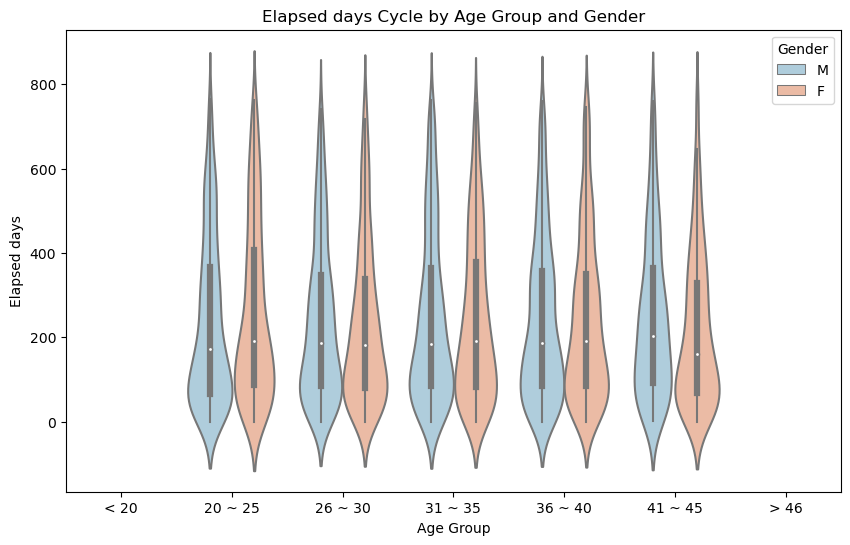

In [12]:
# 연령 구간별, 성별 구매 경과일 확인
plt.figure(figsize=(10, 6))
sns.violinplot(x='age_cat', y='elapsed_days', hue='Gender', data=purchase_date_info, palette='RdBu_r')
plt.title('Elapsed days Cycle by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Elapsed days')
plt.show()

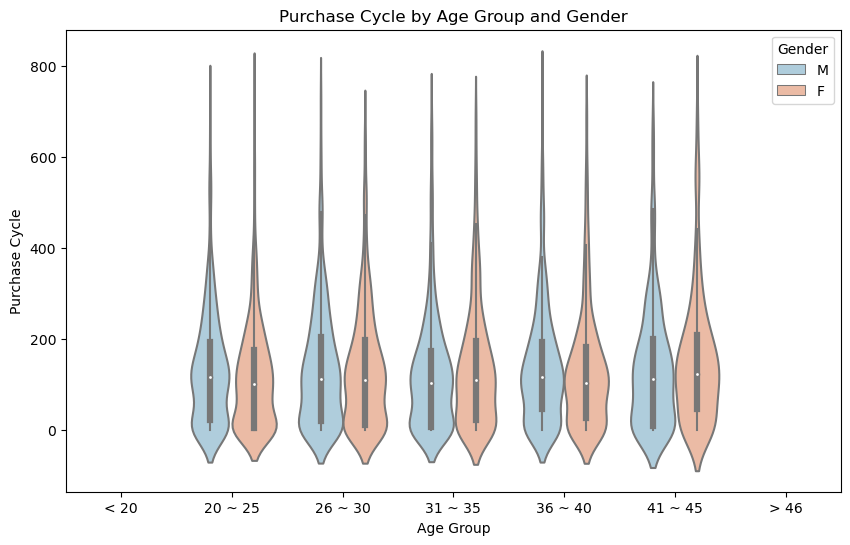

In [13]:
# 연령 구간별, 성별 구매 주기 확인
plt.figure(figsize=(10, 6))
sns.violinplot(x='age_cat', y='purchase_cycle', hue='Gender', data=purchase_date_info, palette='RdBu_r')
plt.title('Purchase Cycle by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Purchase Cycle')
plt.show()

바이올린 플롯을 통해 확인했을 때, 성별, 연령 그룹별 구매 경과일, 구매 주기의 차이는 크게 없는 것으로 보인다.

In [14]:
# 고객별 구매 경과일수를 기준으로 구매 경과일수가 30일 이상인 고객을 대상으로 재구매 유도를 위한 캠페인을 진행하였다고 가정하겠습니다. 
# 캠페인 2013년 12월 31일까지 구매 반응한 고객 

# 구매 경과일이 30일 이상인 고객 추출
purchase_date_info_over_30 = purchase_date_info.loc[purchase_date_info['elapsed_days'] >= 30]

# 고객 수 확인(4675명)
purchase_date_info_over_30['cust_id'].nunique()

4675

In [15]:
# 2013년 12월 31일까지 구매 데이터 추출
transaction_after_20130228 = transaction[(transaction['tran_date'] >= reference_date) & (transaction['tran_date'] <= pd.to_datetime('2013-12-31'))]
purchase_log_over_30_after_20130228 = pd.merge(purchase_date_info_over_30, transaction_after_20130228, how = 'inner', on = 'cust_id')

# 구매 반응한 고객 수 확인(2977명)
purchase_log_over_30_after_20130228['cust_id'].nunique()

2977

In [16]:
# 요일별 구매 건수 차이 확인
# 요일 변수 생성
transaction['days_of_week'] = transaction['tran_date'].dt.day_name()
transaction

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,days_of_week
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,Friday
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop,Thursday
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,TeleShop,Monday
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,e-Shop,Monday
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,TeleShop,Sunday
...,...,...,...,...,...,...,...,...,...,...,...
23048,94340757522,274550,2011-01-25,12,5,1,1264,132.720,1396.720,e-Shop,Tuesday
23049,89780862956,270022,2011-01-25,4,1,1,677,71.085,748.085,e-Shop,Tuesday
23050,85115299378,271020,2011-01-25,2,6,4,1052,441.840,4649.840,MBR,Tuesday
23051,72870271171,270911,2011-01-25,11,5,3,1142,359.730,3785.730,TeleShop,Tuesday


In [17]:
# 요일별 총 구매건수
dow_sales = (transaction.groupby('days_of_week')['transaction_id'].count()).reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()
dow_sales

,days_of_week,transaction_id
0,Monday,3219
1,Tuesday,3269
2,Wednesday,3302
3,Thursday,3318
4,Friday,3361
5,Saturday,3258
6,Sunday,3326


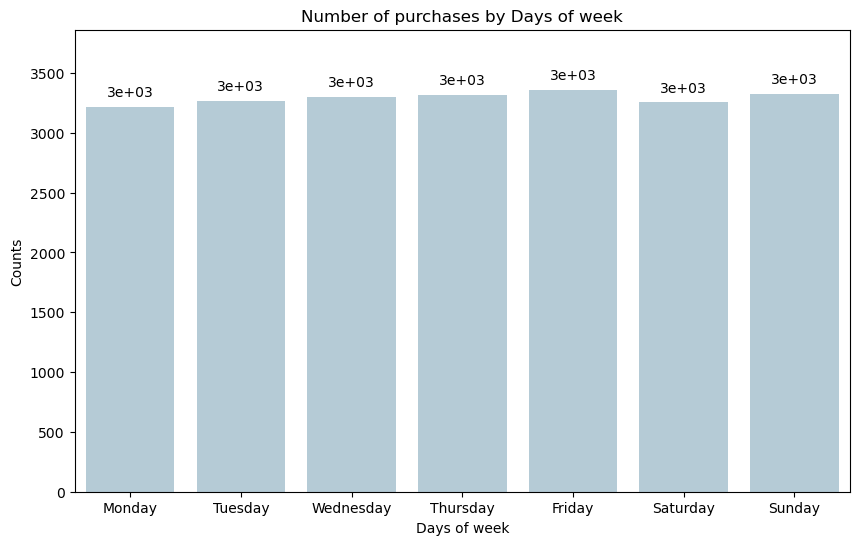

In [18]:
# 성별/연령별 고객 수 시각화
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='days_of_week', y='transaction_id', data=dow_sales, color='#AFCDDC')

# 막대 위에 count 수 표시
for p in barplot.patches:
    if p.get_height() > 0:  # count가 0보다 클 때만 라벨 표시
        barplot.annotate(format(p.get_height(), '.0'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points')

plt.title('Number of purchases by Days of week')
plt.xlabel('Days of week')
plt.ylabel('Counts')


# y 축 범위 조정
barplot.set_ylim(0, dow_sales['transaction_id'].max() + 500)

plt.show()

요일별 구매건수는 크게 차이가 없는 것으로 보인다.

In [22]:
# 2011~2013년 대카테고리 별 월평균 매출액이 가장 높은 카테고리 확인
# 2014년 데이터 삭제
transaction_before_2014 = transaction.loc[transaction['tran_date'] <  pd.to_datetime('2014-01-01')].reset_index(drop=True)

# 월까지 나타내는 변수 생성
transaction_before_2014['tran_month'] = transaction_before_2014['tran_date'].dt.strftime('%Y-%m')

# 월별, 대카테고리별 총 매출액 계산
total_amt_month_cat = transaction_before_2014.groupby(['tran_month', 'prod_cat_code'])['total_amt'].sum().reset_index()

# 카테고리 명칭 결합
total_amt_month_cat = pd.merge(total_amt_month_cat, prod_info[['prod_cat', 'prod_cat_code']].drop_duplicates(), on='prod_cat_code', how='inner')

# 가장 높은 매출월 및 카테고리 확인
total_amt_month_cat.sort_values(by='total_amt', ascending=False)

,tran_month,prod_cat_code,total_amt,prod_cat
146,2011-03,5,398109.400,Books
152,2011-09,5,397969.065,Books
154,2011-11,5,395992.220,Books
163,2012-08,5,394687.215,Books
170,2013-03,5,393130.270,Books
...,...,...,...,...
72,2011-01,3,69149.795,Electronics
120,2012-01,4,67400.580,Bags
0,2011-01,1,31618.470,Clothing
108,2011-01,4,28925.585,Bags


2011년부터 2013년까지 대카테고리를 기준으로 월별 매출액은 대체로 Books가 높았다.

In [24]:
# 각 카테고리별 월평균 매출액의 평균, 분산과 표준 편차 구하기
# prod_cat 단위로 total_amt의 평균, 분산, 표준편차 계산
base_stats = total_amt_month_cat.groupby('prod_cat')['total_amt'].agg(['mean', 'var', 'std']).reset_index()

base_stats.sort_values('mean', ascending=False)

,prod_cat,mean,var,std
1,Books,339932.009444,3.021497e+09,54968.142749
3,Electronics,284476.325972,2.608934e+09,51077.728034
5,Home and kitchen,223243.549028,1.849927e+09,43010.781818
4,Footwear,165679.034444,1.295008e+09,35986.220227
2,Clothing,164999.674306,1.628353e+09,40352.858761
0,Bags,109006.316250,6.809566e+08,26095.146098


월별로 확인했을때 2011년 4월 Bags의 월평균 매출액이 가장 높았다. 그러나 전체 평균을 구했을 때는 Bags는 월평균 매출액이 대카테고리에서 5번째를 기록했다. 이는 Bags의 월평균 매출액의 변동성이 크기 때문으로 생각해볼 수 있다. 표준편차를 확인했을 때에도 표준편차가 큰 것을 확인할 수 있었다.

In [25]:
# 변동 계수를 통해 수치 해석해보기
base_stats['cv'] = base_stats['std'] / base_stats['mean']
base_stats

,prod_cat,mean,var,std,cv
0,Bags,109006.316250,6.809566e+08,26095.146098,0.239391
1,Books,339932.009444,3.021497e+09,54968.142749,0.161703
2,Clothing,164999.674306,1.628353e+09,40352.858761,0.244563
3,Electronics,284476.325972,2.608934e+09,51077.728034,0.179550
4,Footwear,165679.034444,1.295008e+09,35986.220227,0.217204
5,Home and kitchen,223243.549028,1.849927e+09,43010.781818,0.192663


표준편차는 Books 카테고리가 가장 높아 월평균 매출액은 가장 커도 변동폭이 크기 때문에 불안정할 것이라고 판단할 수 있다. 그러나 표준편차는 평균에 영향을 받으므로 월평균 매출액이 가장 큰 Books의 표준편차가 클 가능성이 높다.   
따라서 표준편차를 평균으로 나눠 단위를 보정한 '변동계수'를 통해 비교해보았다.   
변동계수를 확인한 결과 Books의 변동계수는 가장 낮아 오히려 다른 대카테고리에 비해 안정적인 것을 확인할 수 있었다.   
변동계수가 큰 대카테고리는 Clothing, Bags, Footwear로 의류와 관련된 품목들이었다. 이는 의류 품목이 계절 또는 유행하는 시기에 따라 판매량이 변하기 때문으로 추측된다.

## **매출 관점에서 카테고리별 매출 성장 방안**

In [45]:
# 2013년 카테고리 매출 보기
# transaction df에 카테고리 명 결합
transaction_merged = pd.merge(transaction, prod_info, 
                               how="left", 
                               left_on=["prod_cat_code", "prod_subcat_code"], 
                               right_on=["prod_cat_code", "prod_sub_cat_code"])

# 2013년 데이터만 추출
transaction_merged = transaction_merged[(transaction_merged['tran_date'] >= '2013-01') & (transaction_merged['tran_date'] < '2014-01')]
# 월 데이터 생성
transaction_merged['month'] = transaction_merged['tran_date'].dt.strftime('%Y-%m')
transaction_merged

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,days_of_week,prod_cat,prod_sub_cat_code,prod_subcat,month
1065,58387181112,275068,2013-12-31,8,3,5,792,415.800,4375.800,e-Shop,Tuesday,Electronics,8,Personal Appliances,2013-12
1066,21300411973,274568,2013-12-31,2,6,1,1054,110.670,1164.670,Flagship store,Tuesday,Home and kitchen,2,Furnishing,2013-12
1067,25511948871,273541,2013-12-31,3,1,-3,-253,79.695,-838.695,MBR,Tuesday,Clothing,3,Kids,2013-12
1068,45524941068,268722,2013-12-31,10,5,5,124,65.100,685.100,Flagship store,Tuesday,Books,10,Non-Fiction,2013-12
1069,26100869804,273836,2013-12-31,9,3,3,843,265.545,2794.545,e-Shop,Tuesday,Electronics,9,Cameras,2013-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8516,92448979118,274075,2013-01-01,4,3,1,500,52.500,552.500,e-Shop,Tuesday,Electronics,4,Mobiles,2013-01
8517,85997903948,269771,2013-01-01,6,5,2,981,206.010,2168.010,Flagship store,Tuesday,Books,6,DIY,2013-01
8518,69045198533,275228,2013-01-01,7,5,2,177,37.170,391.170,TeleShop,Tuesday,Books,7,Fiction,2013-01
8519,92456095978,269718,2013-01-01,3,2,1,1222,128.310,1350.310,Flagship store,Tuesday,Footwear,3,Women,2013-01


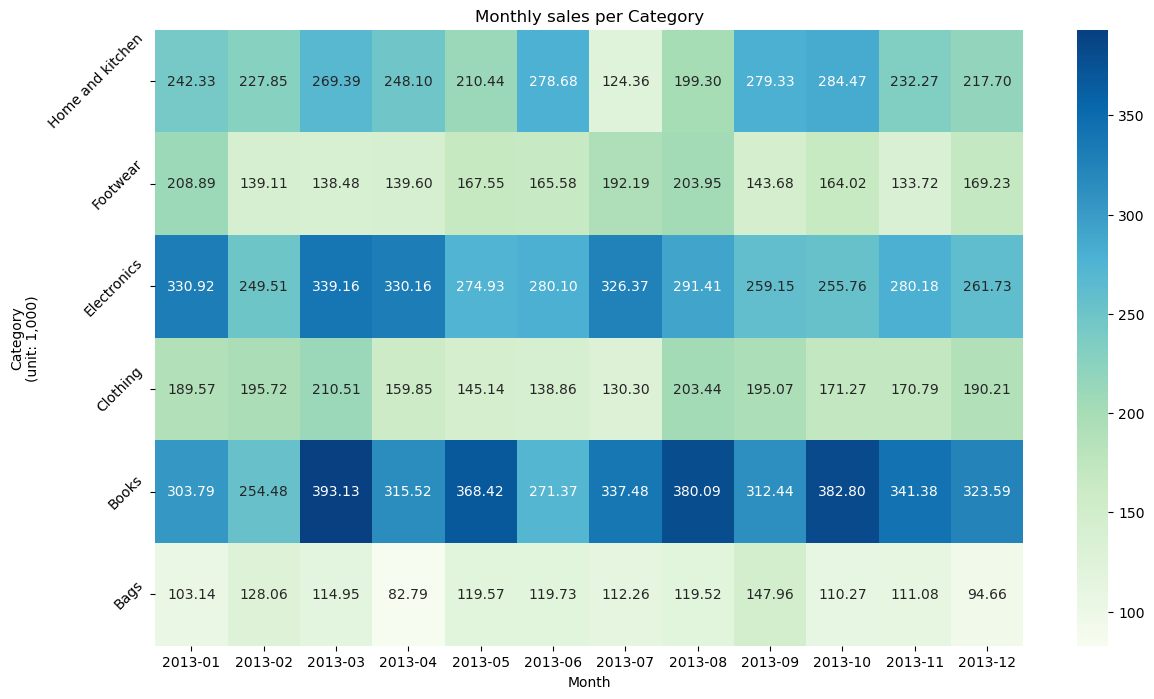

In [59]:
# 월별 카테고리 총 매출액 구하기(단위 : 1000)
total_sales_cat = (transaction_merged.groupby(['month', 'prod_cat'])['total_amt'].sum()/1000).reset_index()

# 월과 연령대별로 1인 평균 매출액을 집계하는 피벗 테이블 생성
pivot_table = total_sales_cat.pivot(index="prod_cat", columns="month", values="total_amt")

# 히트맵 생성
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap="GnBu", annot=True, fmt='.2f')
plt.title("Monthly sales per Category")
plt.xlabel("Month")
plt.ylabel("Category\n(unit: 1,000)")
plt.yticks(rotation=45)
plt.gca().invert_yaxis()

plt.show()

- 카테고리별 매출을 확인했을 때 Books의 총 매출액이 가장 높은 비중을 차지하는 것을 확인할 수 있었다.   
또한 Books는 시기에 따라 판매량이 고루 분포하였다. 따라서 회사의 주 매출원인 Books의 매출을 주의깊게 모니터링하고 그에 따른 조치를 취할 필요가 있다.   
   
- Electronics의 경우 점점 매출이 감소하는 경향을 보였다. 따라서 혹시 다른 경쟁사를 이용하기 때문인지, 사회적으로 고객들이 전자제품 고객을 하지 않는 것인지 파악을 하고, 2014년 3월 현재 신학기 이벤트와 같은 프로모션을 진행하여 매출액을 증가시킬 수 있도록 고민해볼 필요가 있다.   
   
- Clothing, Footwear의 경우 특정 시기에 매출이 낮은 것을 확인할 수 있었다. 이는 특정 시즌에 따라 고객들의 수요가 다를 수 있기 떄문으로 추측된다. 따라서 매출액이 낮은 시기에 시즌오프 행사를 하여 고객들이 관심을 갖을 수 있도록 하는 전략이 필요하다.

In [80]:
# 카테고리별 주문 취소 건수 확인
cancel_transaction = transaction_merged[transaction_merged['Rate'] < 0]
total_cancel = (cancel_transaction.groupby('prod_cat')['transaction_id'].nunique()).reset_index()
total_cancel

,prod_cat,transaction_id
0,Bags,56
1,Books,155
2,Clothing,90
3,Electronics,131
4,Footwear,93
5,Home and kitchen,115


In [81]:
# 전체 주문 건수 확인
(transaction_merged.groupby('prod_cat')['transaction_id'].nunique()).reset_index()

,prod_cat,transaction_id
0,Bags,593
1,Books,1710
2,Clothing,919
3,Electronics,1451
4,Footwear,881
5,Home and kitchen,1230


비교적 카테고리별 매출액과 유사한 순서를 보였다. 따라서 주문 수 자체가 많아서 취소 건수도 많은 것으로 보인다.   
유독 취소 건수가 많은 카테고리는 없으므로 카테고리 구분없이 취소를 한 경우, 추가 할인 쿠폰을 제공하는 등의 방안을 고려해볼 수 있다.

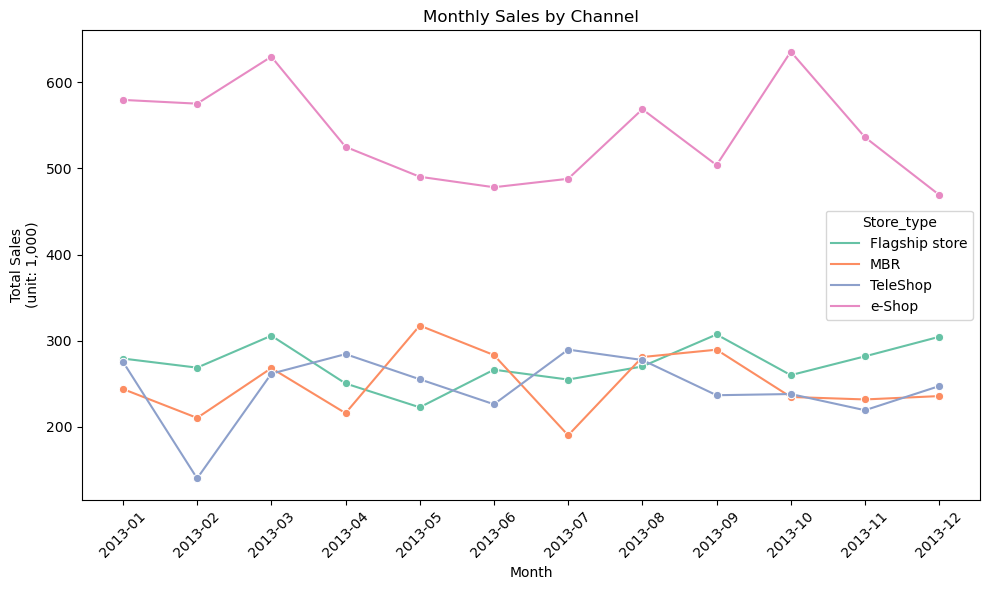

In [76]:
# 판매 채널 별 매출액 확인
total_sales_channel = (transaction_merged.groupby(['month', 'Store_type'])['total_amt'].sum()/1000).reset_index()

# seaborn을 사용하여 라인그래프 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(data=total_sales_channel, x='month', y='total_amt', hue='Store_type', marker='o', palette='Set2')

plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Total Sales\n(unit: 1,000)')
plt.title('Monthly Sales by Channel')
plt.tight_layout()
plt.show()

e-Shop의 매출액 비중이 제일 높았다. 해당 서비스를 비교적 젊은 연령층이 사용하는 것을 앞에서 확인했었다. 이에 간편한 e-Shop 서비스를 가장 많이 사용하는 것으로 추측된다. 따라서 e-Shop의 주문 건수에 집중하여 모니터링하는 것이 필요하다. 또한 특정 시즌에 맞춰 Flagship store를 열어 e-Shop과 연계하여 팝업을 띄우거나 고객들에게 알림을 하는 방안도 고려해볼만 하다.